In [ ]:
import sys
!{sys.executable} -m pip install xlsxwriter

In [ ]:
import pandas as pd                  # Manejo de datos tabulares
import numpy as np                   # Utilidades numéricas
import matplotlib.pyplot as plt      # Gráficos (sin seaborn)
from pathlib import Path             # Rutas multiplataforma
import unicodedata                   # Normalización unicode (acentos/NBSP)
import math                          # Funciones matemáticas (ceil)

In [ ]:
#Funciones
def strip_accents(s: str) -> str:
    # Elimina acentos/diacríticos para facilitar búsquedas por nombre de columna.
    return "".join(c for c in unicodedata.normalize("NFD", str(s)) if unicodedata.category(c) != "Mn")

def clean_colname(s: str) -> str:
    # Limpia espacios al inicio/fin y colapsa espacios múltiples a uno solo.
    s2 = str(s).strip()
    s2 = " ".join(s2.split())
    return s2

def to_float_comma(series: pd.Series) -> pd.Series:
    # Convierte números con coma decimal a float de Python (p. ej., "72,7" -> 72.7).
    return pd.to_numeric(
        series.astype(str).str.replace(".", "", regex=False).str.replace(",", ".", regex=False),
        errors="coerce"   # Si hay texto no convertible, lo pone como NaN.
    )

def clasificar_variable(serie: pd.Series) -> str:
    # Reglas para clasificar el tipo de variable a partir del dtype de pandas.
    if pd.api.types.is_datetime64_any_dtype(serie):
        return "Temporal (cuantitativa continua)"
    if pd.api.types.is_integer_dtype(serie):
        return "Cuantitativa discreta"
    if pd.api.types.is_float_dtype(serie):
        return "Cuantitativa continua"
    if pd.api.types.is_bool_dtype(serie):
        return "Cualitativa (binaria)"
    return "Cualitativa"  # objeto/categoría/strings

In [39]:
# 0) Cargar y normalizar datos
RUTA = Path("Datos.csv")                                  # Cambia si tu archivo se llama distinto
if not RUTA.exists():
    RUTA = Path("/mnt/data/Tarea1.Datos-cuant-Gamma.csv") # Fallback (donde ya lo corrimos)

ENCODINGS = ["utf-8", "latin-1", "cp1252"]                # Codificaciones típicas en ES
SEPS      = [";", ",", "\t", "|"]                         # Separadores comunes

def read_csv_smart(path: Path) -> tuple[pd.DataFrame, str, str]:
    # Prueba combinaciones encoding/sep hasta cargar bien el CSV
    for enc in ENCODINGS:
        for sep in SEPS:
            try:
                df_try = pd.read_csv(path, encoding=enc, sep=sep)
                # Evita falso positivo: si queda 1 columna y se ven separadores, no era ese sep
                if df_try.shape[1] == 1 and any(s in str(df_try.iloc[0,0]) for s in [",",";","|","\t"]):
                    continue
                return df_try, enc, sep
            except Exception:
                continue
    raise ValueError("No fue posible leer el CSV con diferentes codificaciones/separadores.")

df, used_enc, used_sep = read_csv_smart(RUTA)             # ← Carga robusta
print(f"Leído con encoding='{used_enc}' sep='{used_sep}'. Cols: {list(df.columns)}")

df.columns = [clean_colname(c) for c in df.columns]       # Limpia nombres de columnas

# === Mapear nombres de columnas que usaremos (constantes) ===================
COL_CLIENTES_NUEVOS = "Clientes nuevos"
COL_RETENCION_PCT   = "Tasa de retención de clientes (%)"
COL_VISITAS         = "Número de visitas comerciales realizadas"
COL_VENTAS          = "Ventas totales"

# Detectar columna de satisfacción de forma robusta (con o sin acento)
COL_SATISFACCION = next(
    (c for c in df.columns if "satisfaccion" in strip_accents(c).lower()),
    None
)

# === Conversión de columnas con coma decimal a float ========================
if COL_RETENCION_PCT in df.columns:
    df[COL_RETENCION_PCT] = to_float_comma(df[COL_RETENCION_PCT])
if COL_SATISFACCION:
    df[COL_SATISFACCION] = to_float_comma(df[COL_SATISFACCION])

# === Forzar numéricos en columnas clave (enteras) ===========================
for col in [COL_CLIENTES_NUEVOS, COL_VISITAS, COL_VENTAS]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")   # Int64 (nullable)

# === Agregar columnas sintéticas SOLO si faltan =============================
np.random.seed(42)                                                          # Reproducible
n = len(df)
MES_NOMBRES = {1:"Enero",2:"Febrero",3:"Marzo",4:"Abril",5:"Mayo",6:"Junio",
               7:"Julio",8:"Agosto",9:"Septiembre",10:"Octubre",11:"Noviembre",12:"Diciembre"}

if "mes_num" not in df.columns:
    df["mes_num"] = np.tile(np.arange(1,13), math.ceil(n/12))[:n]
if "mes_nombre" not in df.columns:
    df["mes_nombre"] = df["mes_num"].map(MES_NOMBRES)
if "Asesor" not in df.columns:
    df["Asesor"] = np.tile(["Asesor_A","Asesor_B","Asesor_C"], math.ceil(n/3))[:n]
if "Ciudad" not in df.columns:
    df["Ciudad"] = np.tile(["Bogotá","Medellín","Cali"], math.ceil(n/3))[:n]

# (Opcional) Vista rápida
print(df.head(10))
print(df.dtypes)

Leído con encoding='latin-1' sep=';'. Cols: ['Clientes nuevos', 'Tasa de retención de clientes (%)', ' Número de visitas comerciales realizadas', ' Ventas totales ', 'satisfaccion']
   Clientes nuevos  Tasa de retención de clientes (%)  \
0               12                               72.7   
1                6                               75.8   
2                7                               50.0   
3                7                               60.2   
4               11                               69.0   
5               11                               71.1   
6               10                               77.2   
7               10                               76.0   
8               13                               85.3   
9               14                               72.5   

   Número de visitas comerciales realizadas  Ventas totales  satisfaccion  \
0                                        50          315837           3.8   
1                                   

In [40]:
data= df
# 1) Cuadro de variables y clasificación Tarea a
tabla_variables = pd.DataFrame({
    "variable": data.columns,                                      # Nombre de columna.
    "tipo_inferido": [str(data[c].dtype) for c in data.columns],   # dtype de pandas (int64, float64, object, etc.).
    "clasificacion": [clasificar_variable(data[c]) for c in data.columns]  # Clasificación humana.
})
print("\n[1] Variables y clasificación")             # Imprime título de sección.
print(tabla_variables.to_string(index=False))        # Muestra la tabla de manera legible en consola.



[1] Variables y clasificación
                                variable tipo_inferido         clasificacion
                         Clientes nuevos         Int64 Cuantitativa discreta
       Tasa de retención de clientes (%)       float64 Cuantitativa continua
Número de visitas comerciales realizadas         Int64 Cuantitativa discreta
                          Ventas totales         Int64 Cuantitativa discreta
                            satisfaccion       float64 Cuantitativa continua
                                 mes_num         int64 Cuantitativa discreta
                              mes_nombre        object           Cualitativa
                                  Asesor        object           Cualitativa
                                  Ciudad        object           Cualitativa


In [41]:
#2) Resumen numérico Tarea b
num_cols   = [c for c in data.columns if pd.api.types.is_numeric_dtype(data[c])]
resumen_num = (data[num_cols].agg(["mean","min","max","std"]).T
               .reset_index()
               .rename(columns={"index":"variable",
                                "mean":"promedio","min":"minimo",
                                "max":"maximo","std":"desviacion_estandar"}))
print("\n[2] Resumen numérico (promedio, min, max, sd)")
print(resumen_num.to_string(index=False))


[2] Resumen numérico (promedio, min, max, sd)
                                variable      promedio  minimo   maximo  desviacion_estandar
                         Clientes nuevos     10.166667     1.0     20.0             3.410684
       Tasa de retención de clientes (%)     74.788333    50.0     96.5             9.618081
Número de visitas comerciales realizadas     56.083333    40.0     69.0             9.422821
                          Ventas totales 355227.100000 50718.0 649149.0        128978.982813
                            satisfaccion      3.930000     2.9      4.9             0.421981
                                 mes_num      6.500000     1.0     12.0             3.481184


In [42]:
# 3) Total de ventas por mes Tarea c
ventas_mes = (data
              .groupby(["mes_num","mes_nombre"], as_index=False)[COL_VENTAS]
              .sum()
              .sort_values("mes_num"))
print(
    "\n[3] Total de ventas por mes\n",ventas_mes.to_string(index=False),f"\n\n[3] Total de ventas: {data[COL_VENTAS].sum()}")


[3] Total de ventas por mes
  mes_num mes_nombre  Ventas totales
       1      Enero         1752700
       2    Febrero         1563798
       3      Marzo         1633681
       4      Abril         1539613
       5       Mayo         1751577
       6      Junio         1831289
       7      Julio         1996368
       8     Agosto         1716505
       9 Septiembre         2179875
      10    Octubre         1937264
      11  Noviembre         1703401
      12  Diciembre         1707555 

[3] Total de ventas: 21313626



[4] Promedio mensual de tasa de conversión por asesor
  Asesor  mes_num mes_nombre  tasa_conversion_pct
Asesor_A        1      Enero            20.952439
Asesor_B        2    Febrero            21.708506
Asesor_C        3      Marzo            21.367277
Asesor_A        4      Abril            15.716573
Asesor_B        5       Mayo            17.293858
Asesor_C        6      Junio            17.822837
Asesor_A        7      Julio            18.594621
Asesor_B        8     Agosto            15.696652
Asesor_C        9 Septiembre            23.656078
Asesor_A       10    Octubre            23.798916
Asesor_B       11  Noviembre            14.442472
Asesor_C       12  Diciembre            16.032854


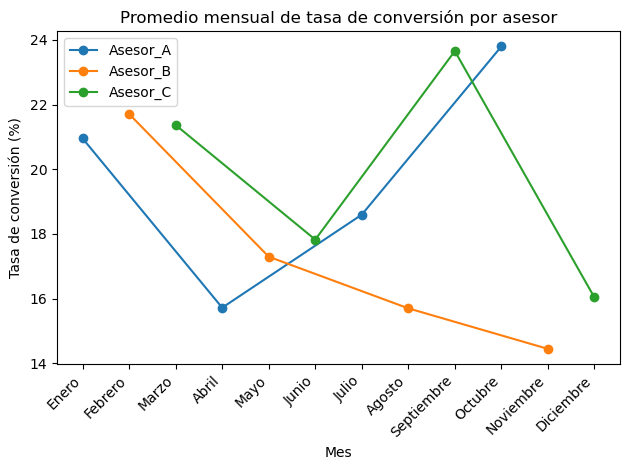

In [43]:
# 4) Tasa de conversión + promedio mensual por asesor + gráfico. Tarea D
data["tasa_conversion_pct"] = np.where(
    data[COL_VISITAS].astype(float) > 0,
    (data[COL_CLIENTES_NUEVOS].astype(float) / data[COL_VISITAS].astype(float)) * 100.0,
    np.nan
)
conv_mensual_asesor = (data
                       .groupby(["Asesor","mes_num","mes_nombre"], as_index=False)["tasa_conversion_pct"]
                       .mean()
                       .sort_values(["mes_num","Asesor"]))
print("\n[4] Promedio mensual de tasa de conversión por asesor")
print(conv_mensual_asesor.to_string(index=False))

plt.figure()
for asesor, sub in conv_mensual_asesor.groupby("Asesor"):
    sub = sub.sort_values("mes_num")
    plt.plot(sub["mes_num"], sub["tasa_conversion_pct"], marker="o", label=str(asesor))
plt.xticks(ticks=range(1,13), labels=[MES_NOMBRES[i] for i in range(1,13)], rotation=45, ha="right")
plt.title("Promedio mensual de tasa de conversión por asesor")
plt.xlabel("Mes"); plt.ylabel("Tasa de conversión (%)")
plt.legend(loc="best"); plt.tight_layout(); plt.show()


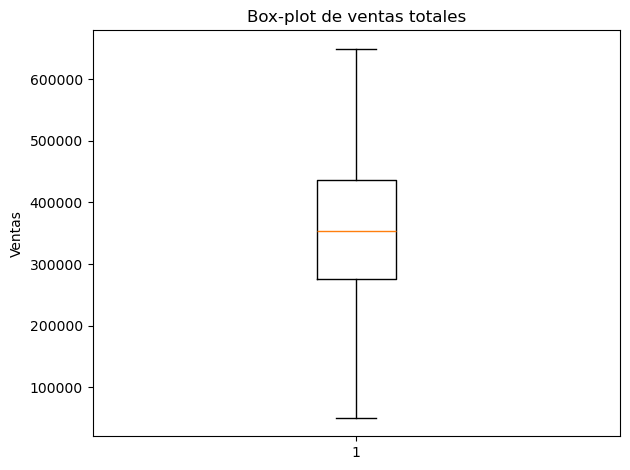

In [44]:
# 5) Box-plot de ventas. Tarea E
plt.figure()
plt.boxplot(data[COL_VENTAS].dropna())
plt.title("Box-plot de ventas totales")
plt.ylabel("Ventas")
plt.tight_layout(); plt.show()

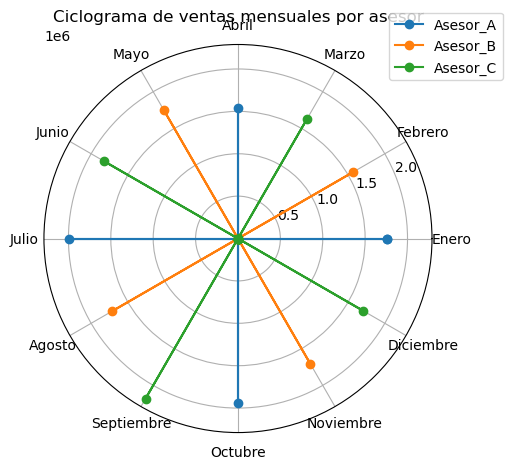

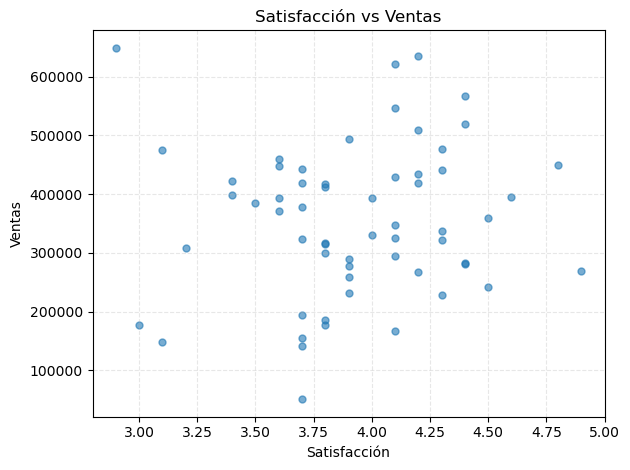

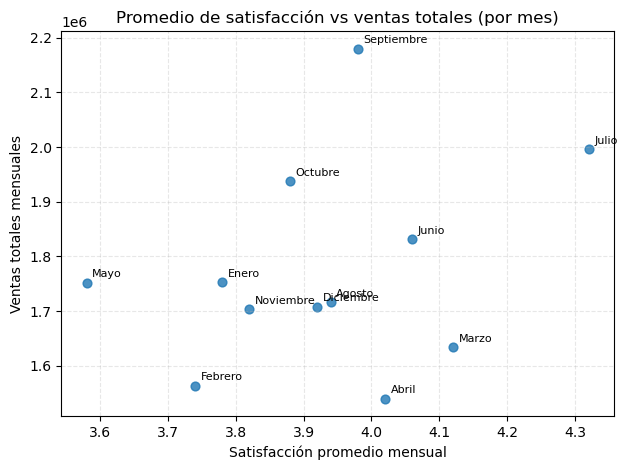

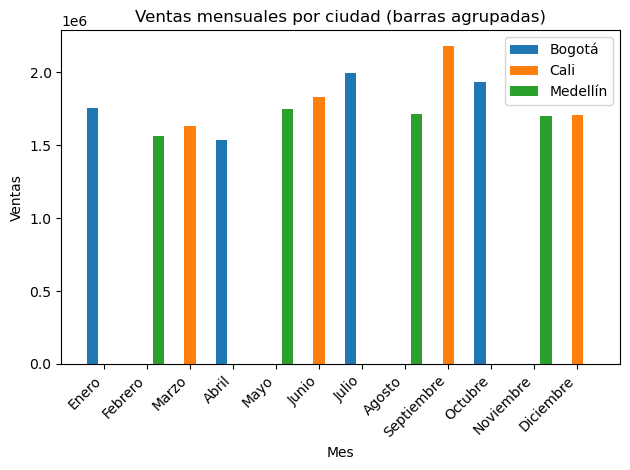

In [ ]:
# 6) Gráficos adicionales. Tarea f
# i) Ciclograma (polar) de ventas mensuales por asesor
angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
ventas_mes_asesor = (data
                     .groupby(["Asesor","mes_num"], as_index=False)[COL_VENTAS]
                     .sum())
plt.figure()
ax = plt.subplot(111, polar=True)
for asesor, sub in ventas_mes_asesor.groupby("Asesor"):
    serie = pd.Series(index=range(1,13), dtype=float)
    serie[sub["mes_num"].values] = sub[COL_VENTAS].values
    serie = serie.fillna(0.0)
    vals = np.append(serie.values, serie.values[0])
    angs = np.append(angles, angles[0])
    ax.plot(angs, vals, marker="o", label=str(asesor))
ax.set_xticks(angles)
ax.set_xticklabels([MES_NOMBRES[i] for i in range(1,13)])
ax.set_title("Ciclograma de ventas mensuales por asesor")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout(); plt.show()

# ii) Dispersión satisfacción vs ventas
# Dispersión satisfacción vs ventas
# Asegura numérico y filtra filas válidas para evitar error con matplot
COL_SAT = "satisfaccion"  # ajusta al nombre real de tu columna
data[COL_SAT] = pd.to_numeric(data[COL_SAT], errors="coerce")
mask = data[[COL_SAT, COL_VENTAS]].notna().all(axis=1)
df_scatter = data.loc[mask, [COL_SAT, COL_VENTAS]]

plt.figure()
plt.scatter(df_scatter[COL_SAT], df_scatter[COL_VENTAS], s=25, alpha=0.6)
plt.title("Satisfacción vs Ventas")
plt.xlabel("Satisfacción")
plt.ylabel("Ventas")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Relación mensual: promedio de satisfacción vs. total de ventas por mes
rel_mensual = (
    data.groupby("mes_num", as_index=False)
        .agg(sat_prom=(COL_SAT, "mean"), ventas_tot=(COL_VENTAS, "sum"))
        .sort_values("mes_num")
)

plt.figure()
plt.scatter(rel_mensual["sat_prom"], rel_mensual["ventas_tot"], s=40, alpha=0.8)
for _, r in rel_mensual.iterrows():
    plt.annotate(str(MES_NOMBRES.get(int(r["mes_num"]), int(r["mes_num"]))),
                 (r["sat_prom"], r["ventas_tot"]), xytext=(4,4), textcoords="offset points", fontsize=8)
plt.title("Promedio de satisfacción vs ventas totales (por mes)")
plt.xlabel("Satisfacción promedio mensual")
plt.ylabel("Ventas totales mensuales")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# iii) Barras agrupadas: ventas mensuales por ciudad
pv = (
    data.groupby(["Ciudad", "mes_num"], as_index=False)[COL_VENTAS]
        .sum()
        .pivot(index="mes_num", columns="Ciudad", values=COL_VENTAS)
        .sort_index()
        .fillna(0.0)
)

plt.figure()
idx = np.arange(len(pv.index))                  # posiciones por mes
n_series = max(1, pv.shape[1])                  # número de ciudades
width = 0.8 / n_series                          # ancho dinámico por barra

for i, ciudad in enumerate(pv.columns):
    plt.bar(idx + i*width, pv[ciudad].to_numpy(),
            width=width, label=str(ciudad))

# etiquetar eje X con nombres de mes centrados
plt.xticks(idx + (n_series-1)*width/2,
           [MES_NOMBRES.get(m, str(m)) for m in pv.index],
           rotation=45, ha="right")

plt.title("Ventas mensuales por ciudad (barras agrupadas)")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [49]:
# 7) Dos cálculos adicionales (descriptiva). Tarea G
# A) Ticket promedio por visita (promedio mensual)
data["ticket_promedio_por_visita"] = np.where(
    data[COL_VISITAS].astype(float) > 0,
    data[COL_VENTAS].astype(float) / data[COL_VISITAS].astype(float),
    np.nan
)
ticket_promedio_por_mes = (data
                           .groupby(["mes_num","mes_nombre"], as_index=False)["ticket_promedio_por_visita"]
                           .mean()
                           .sort_values("mes_num"))
print("\n[7A] Ticket promedio por visita (promedio mensual)")
print(ticket_promedio_por_mes.to_string(index=False))

# B) Correlación Ventas vs Retención (%)
if COL_RETENCION_PCT in data.columns:
    corr = np.corrcoef(data[COL_RETENCION_PCT].astype(float), data[COL_VENTAS].astype(float))[0,1]
    print("\n[7B] Correlación Pearson Ventas vs Retención (%):", round(float(corr), 4))
else:
    print("\n[7B] Aviso: no hay columna de retención para calcular correlación.")



[7A] Ticket promedio por visita (promedio mensual)
 mes_num mes_nombre  ticket_promedio_por_visita
       1      Enero                 7430.487708
       2    Febrero                 6316.747613
       3      Marzo                 6465.516303
       4      Abril                 5148.947187
       5       Mayo                 7012.701270
       6      Junio                 6185.709569
       7      Julio                 7291.915728
       8     Agosto                 5779.777055
       9 Septiembre                 8921.564343
      10    Octubre                 7269.832356
      11  Noviembre                 5827.717844
      12  Diciembre                 5635.847211

[7B] Correlación Pearson Ventas vs Retención (%): 0.3018


In [48]:
# 8) Exportación a Excel
# Asegura ruta y extensión .xlsx
out_dir = Path("salidas")
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / "reporte.xlsx"

# Helper: escribir solo si el objeto existe y tiene datos
def write_df(writer, df_name, sheet):
    obj = globals().get(df_name, None)
    if isinstance(obj, pd.DataFrame) and not obj.empty:
        obj.to_excel(writer, sheet_name=sheet, index=False)
        print(f"✓ {sheet}: {obj.shape[0]} filas, {obj.shape[1]} cols")
    else:
        print(f"⚠ {sheet}: no se escribió (no existe o está vacío)")

with pd.ExcelWriter(out_file, engine="xlsxwriter") as writer:
    write_df(writer, "tabla_variables",       "Variables")
    write_df(writer, "resumen_num",           "ResumenNumerico")
    write_df(writer, "ventas_mes",            "VentasPorMes")
    write_df(writer, "conv_mensual_asesor",   "ConvMensualAsesor")
    write_df(writer, "ventas_mes_ciudad",     "VentasMesCiudad")
    write_df(writer, "ticket_promedio_por_mes","TicketPromedioMes")

print(f"\n✅ Exportado: {out_file.resolve()}")

✓ Variables: 9 filas, 3 cols
✓ ResumenNumerico: 6 filas, 5 cols
✓ VentasPorMes: 12 filas, 3 cols
✓ ConvMensualAsesor: 12 filas, 4 cols
✓ VentasMesCiudad: 12 filas, 4 cols
✓ TicketPromedioMes: 12 filas, 3 cols

✅ Exportado: C:\Users\ASUS\Desktop\VS CODE\Bioestadistica 2\salidas\reporte.xlsx
